In [ ]:
import pandas as pd
from tsai.all import *
from datetime import timedelta
from winkie.dlc_importer import *


In [ ]:
def generate_results(decoded_predictions, behaviour_lookup):
    last_behaviour = None
    bouts = []
    for frame, i in enumerate(preds):
        current_behaviour = i.item()
        if current_behaviour != last_behaviour:
            # new bout starting
            bouts.append([frame, i.item(), 1])
            last_behaviour = current_behaviour
        else:
            # new frame in same bout
            bouts[-1][2] = bouts[-1][2] + 1
    
    b_lookup = ['eating', 'fluffing', 'head_shake', 'preening', 'standing', 'tail_shake', 'walking']
    rows = []
    for b in bouts:
        frame = b[0]
        start_time = frame / 119.88
        start_time = timedelta(seconds=start_time)
        
        duration_frames = b[2]
        duration_time = timedelta(seconds=(duration_frames / 119.88))
        
        behaviour = b_lookup[b[1]]
        row = [frame, start_time, duration_frames, duration_time, behaviour]
        rows.append(row)
    return pd.DataFrame(rows, columns=['starting_frame', 'starting_seconds', 'duration_frames', 'duration_time', 'behvaiour'])

def create_window(hdf_file):
    features = [('head', 'x'), ('head', 'y'), 
            ('tail', 'x'), ('tail', 'y'),  
            
            ('left_neck', 'x'), ('left_neck', 'y'), 
            ('right_neck', 'x'), ('right_neck', 'y'), 
            
            ('left_up_wing', 'x'), ('left_up_wing', 'y'),
            ('left_middle_wing', 'x'), ('left_middle_wing', 'y'),
            ('left_down_wing', 'x'), ('left_down_wing', 'y'),
            
            ('right_up_wing', 'x'), ('right_up_wing', 'y'),
            ('right_middle_wing', 'x'), ('right_middle_wing', 'y'),
            ('right_down_wing', 'x'), ('right_down_wing', 'y'),
    ]
    
    # import and normalize
    imp = DLCImporter()
    df_new = imp.import_hdf(hdf_file)
    df_new = transform_to_relative(df_new, 'body')
    df_new = add_middle_neck(df_new)
    df_new = add_rotation(df_new)
    df_new = apply_rotation(df_new)
    df_new
    
    x, _ = SlidingWindow(16, get_x=features)(df_new)
    return x

def predict_new_data(x, learner):
    test_ds = learn.dls.dataset.add_test(x)
    test_dl = learn.dls.valid.new(test_ds)
    probas, _, preds = learn.get_preds(dl=test_dl, with_decoded=True, reorder=False)
    return probas, preds


In [ ]:

gc.collect()
learn = load_learner_all(path='inception_time', dls_fname='dls', model_fname='model', learner_fname='learner')
b_lookup = ['eating', 'fluffing', 'head_shake', 'preening', 'standing', 'tail_shake', 'walking']

x = create_window("results/unlabelled/233_boxhab_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5")

probas, preds = predict_new_data(x, learn)
print(probas)
df = generate_results(preds, b_lookup)

tensor([[2.6143e-04, 4.6947e-04, 5.2968e-04,  ..., 9.5331e-01, 1.1164e-04,
         4.7587e-03],
        [2.5099e-04, 4.5244e-04, 5.0960e-04,  ..., 9.5312e-01, 1.0494e-04,
         4.4325e-03],
        [2.5724e-04, 4.5066e-04, 4.8239e-04,  ..., 9.5230e-01, 1.0447e-04,
         4.1662e-03],
        ...,
        [1.6283e-03, 3.9915e-04, 7.4498e-03,  ..., 9.6028e-01, 6.5984e-04,
         2.4058e-02],
        [1.4340e-03, 4.3116e-04, 7.3200e-03,  ..., 9.6201e-01, 6.8172e-04,
         2.2784e-02],
        [1.2696e-03, 4.4428e-04, 9.0615e-03,  ..., 9.5912e-01, 7.9114e-04,
         2.3520e-02]])


In [ ]:
df.to_csv("233_boxhab1.csv")

## Gantt Charts

Visualize behaviour over time as a Gantt chart

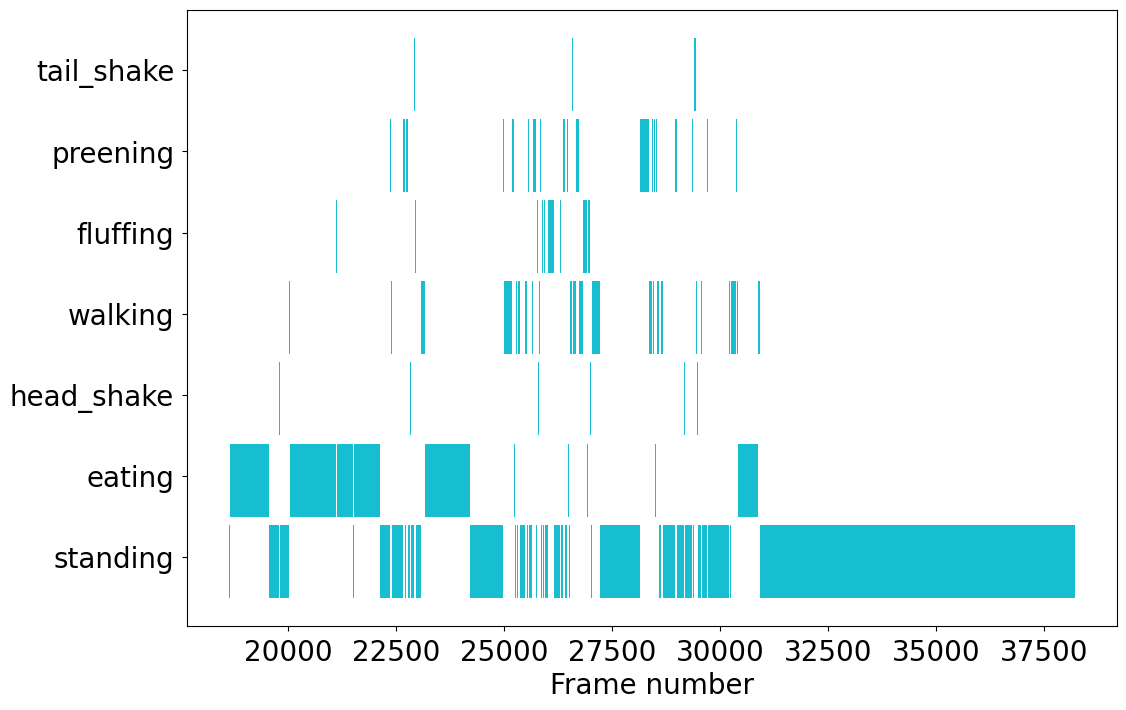

In [ ]:
import matplotlib.pyplot as plt

plt.style.use(['default', 'seaborn-paper'])
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['legend.fontsize'] = 20

def plot_gantt(df, start=-1, end=-1):
    if not (start == -1 or end == -1):
        df = df[(df['starting_frame'] > start) & (df['starting_frame'] < end)]
    
    behaviours = {b : (i+1)*10 for i, b in enumerate( dict.fromkeys(df['behvaiour']) )}
    
    fig, ax_gnt = plt.subplots(figsize = (12, 8))
    
    # Add bars for each duration
    for i, row in df.iterrows():
        ax_gnt.broken_barh([(row['starting_frame'], row['duration_frames'])], (behaviours[row['behvaiour']], 9),
                            facecolors = ('tab:cyan')) 
    
    ax_gnt.grid(False)

    ax_gnt.set_yticks([i + 5 for i in behaviours.values()]) 
    ax_gnt.set_yticklabels(dict.fromkeys(df['behvaiour']).keys()) 
    
    ax_gnt.set_xlabel("Frame number")
    
df = pd.read_csv('877monhab1_ts.csv')
plot_gantt(df, 15000, 31000)
plt.savefig("figures/gantt.svg")

# Rendering predictions on new video

In [ ]:
gc.collect()
learn = load_learner_all(path='inception_time', dls_fname='dls', model_fname='model', learner_fname='learner')
b_lookup = ['eating', 'fluffing', 'head_shake', 'preening', 'standing', 'tail_shake', 'walking']

x = create_window("233_boxhab_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5")

probas, preds = predict_new_data(x, learn)

In [ ]:
import cv2
import numpy as np


def render_video(input_file, output_file, preds, probas, behaviour, start, end):
    
    np.set_printoptions(precision=2)

    cap = cv2.VideoCapture(input_file)
    framerate = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, framerate, (1280,  960))
    
    frame_number = start
    cap.set(cv2.CAP_PROP_POS_FRAMES, start)
    
    while True:
        ret, frame = cap.read()
        frame_number = frame_number + 1

        if frame_number > end:
            break
        if ret:

            b = preds[frame_number].item()
            b = behaviour[b]
            proba = str(probas[frame_number])
            
            black_color = (0,0,0)
            cv2.rectangle(frame, (60, 20), (400, 330), black_color, -1)
            
            cv2.putText(frame, b, (70, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (130, 255, 130), 2, cv2.LINE_AA)
#             cv2.putText(frame, proba, (70, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (130, 255, 130), 1, cv2.LINE_AA)


            for i, v in enumerate(probas[frame_number]):
                label = behaviour[i]
                y_pos = 120 + 30 * i
                x_pos = 250

                cv2.putText(frame, label, (70, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 1, (130, 255, 130), 1, cv2.LINE_AA)

                bar = (int(x_pos + 100 * probas[frame_number][i].item()), y_pos)
                cv2.line(frame, (x_pos, y_pos), bar, (0,0,255), 10)

            out.write(frame)
        else:
            continue

    cap.release()
    out.release()  
    

In [ ]:
gc.collect()
learn = load_learner_all(path='inception_time', dls_fname='dls', model_fname='model', learner_fname='learner')
x = create_window("233_boxhab_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5")
probas, preds = predict_new_data(x, learn)
render_video('233_boxhab_gopro_cut_day1.MP4', 'standing_eating.mp4', preds, probas, b_lookup, 10, 500)

In [ ]:
gc.collect()
learn = load_learner_all(path='inception_time', dls_fname='dls', model_fname='model', learner_fname='learner')
x = create_window("results/unlabelled/877_boxhab_gopro_cut_day2DLC_resnet50_goprovrJul24shuffle1_1030000.h5")
probas, preds = predict_new_data(x, learn)

In [ ]:
render_video('videos/877_boxhab_gopro_cut_day2.MP4', 'predicted_videos/tail_shake.mp4', preds, probas, b_lookup, 30050, 30240)

In [ ]:
render_video('videos/877_boxhab_gopro_cut_day2.MP4', 'predicted_videos/tail_shake2.mp4', preds, probas, b_lookup, 24000, 24150)

In [ ]:
render_video('videos/877_boxhab_gopro_cut_day2.MP4', 'predicted_videos/head_shake.mp4', preds, probas, b_lookup, 22450, 22700)

In [ ]:
render_video('videos/877_boxhab_gopro_cut_day2.MP4', 'predicted_videos/preening.mp4', preds, probas, b_lookup, 30900, 31300)

In [ ]:
gc.collect()
learn = load_learner_all(path='inception_time', dls_fname='dls', model_fname='model', learner_fname='learner')
x = create_window("results/unlabelled/251_boxhab_gopro_cut_day2DLC_resnet50_goprovrJul24shuffle1_1030000.h5")
probas, preds = predict_new_data(x, learn)

In [ ]:
render_video('videos/251_boxhab_gopro_cut_day2.MP4', 'predicted_videos/fluffing.mp4', preds, probas, b_lookup, 33800, 33900)

In [ ]:
render_video('videos/251_boxhab_gopro_cut_day2.MP4', 'predicted_videos/fluffing2.mp4', preds, probas, b_lookup, 61700, 61900)

In [ ]:
render_video('videos/251_boxhab_gopro_cut_day2.MP4', 'predicted_videos/preening2.mp4', preds, probas, b_lookup, 35100, 35300)

In [ ]:
render_video('videos/251_boxhab_gopro_cut_day2.MP4', 'predicted_videos/preening3.mp4', preds, probas, b_lookup, 37000, 37200)

In [ ]:
gc.collect()
learn = load_learner_all(path='inception_time', dls_fname='dls', model_fname='model', learner_fname='learner')
x = create_window("results/unlabelled/877_monhab_gopro_cut_day5DLC_resnet50_goprovrJul24shuffle1_1030000.h5")
probas, preds = predict_new_data(x, learn)

In [ ]:
render_video('videos/877_monhab_gopro_cut_day5.MP4', 'predicted_videos/fluffing3.mp4', preds, probas, b_lookup, 20500, 20800)

In [ ]:
render_video('videos/877_monhab_gopro_cut_day5.MP4', 'predicted_videos/walking.mp4', preds, probas, b_lookup, 39100, 39500)